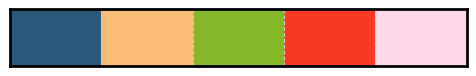

In [2]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(r'..')
sys.path.append(r'.')
%load_ext autoreload
%autoreload 2

from process_data import process_mutation_data
from statistical_test import *

In [3]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart', density_norm='area', width=0.8, x_order=None):
    # tol palette, color-blind friendly
    custom_palette = {'Zest-all': '#FABC75', 'Zest-saved': '#F83A25', 'GEX-all': '#2A587A'}
    tmp_ax = sns.violinplot(data=df, x='benchmark_name', y='mutation', hue='algorithm', 
                            split=split, inner=inner, density_norm=density_norm, palette=custom_palette, 
                            width=width, linewidth=1.0, order=x_order, common_norm=True)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    for l in tmp_ax.lines:
        l.set_linestyle(':')
        l.set_linewidth(1)
        l.set_color('black')
        l.set_alpha(0.8)
    for l in tmp_ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.6)
        l.set_color('#F7F056')
        l.set_alpha(0.8)
        
    # get rid of ticks for empty columns (levels)
    if x_order:
        x_arr = np.array(x_order)
        position_arr = np.array(range(0, len(x_order)))
        positions = [p for p, order in zip(position_arr, x_arr) if 'NA' not in order]
        filtered_x = [e for e in list(x_order) if 'NA' not in e]
        tmp_ax.set_xticks(positions)
        tmp_ax.set_xticklabels(filtered_x)
        plt.xticks(rotation=30)

    tmp_ax.set(xlabel='Benchmark', ylabel='Mutation Distance from Parent Input (%)')
    # tmp_ax.grid(False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [4]:
def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [5]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index 
    # median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [6]:
# statistical tests
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # Warning: large and unequal sample sizes will result in timeout; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices) 
    return stats_df

# RQ1: How destructive are Zest's mutations in general? Are disruptive mutations beneficial for fuzzing?

In [7]:
experiment_name1 = 'ei-d430-m1'
experiment_name2 = 'ei-d430-m2'
# process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name1), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"], 'mutation1')
# process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name2), [False, True], ["testWithGenerator"], ["zest", "ei-no-havoc"], 'mutation2')
# load the df from pickle
# mutation_df1 = pd.read_pickle('./mutation1.pkl')
# mutation_df2 = pd.read_pickle('./mutation2.pkl')
# mutation_df = pd.concat([mutation_df1, mutation_df2], ignore_index=True, sort=False)
# mutation_df.to_pickle('./mutation.pkl')

In [8]:
experiment_name = 'v_dec10'
mutation_df = pd.read_pickle('./mutation.pkl')

In [9]:
new_label_names = {'zest-testWithGenerator': 'Zest-all', 'zest-testWithGenerator-saved_only': 'Zest-saved', 'ei-no-havoc-testWithGenerator': 'GEX-all', 'ei-no-havoc-testWithGenerator-saved_only': 'GEX-saved'}
mutation_df['algorithm'] = mutation_df['algorithm'].map(new_label_names)
print(mutation_df['algorithm'].unique())

['Zest-all' 'Zest-saved' 'GEX-all' 'GEX-saved']


In [10]:
zest_df = mutation_df[mutation_df['algorithm'].str.contains('Zest')]
# ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
all_input_df = mutation_df[mutation_df['algorithm'].str.contains('all')]
print(all_input_df.benchmark_name.unique())

['ant' 'maven' 'rhino' 'closure' 'chocopy' 'gson' 'jackson']


In [11]:
non_zero_mutation_df = mutation_df[mutation_df['mutation'] != 0]

In [12]:
len(zest_df)

350986871

In [ ]:
# zest all inputs vs. zest saved inputs
violin_plot_for_mutation_distance(zest_df, experiment_name, 'rq1_zest_all_vs_saved', width=5.0)

: 

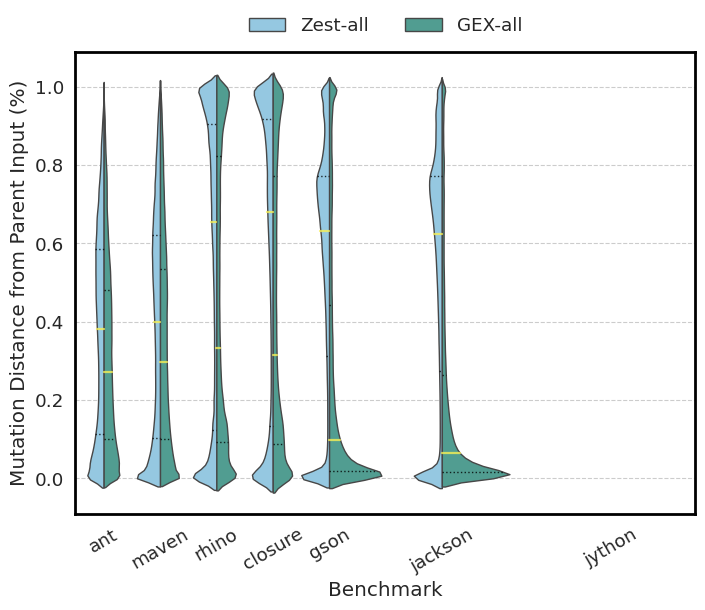

In [ ]:
x_order = ('ant', 'maven', 'rhino', 'closure', 'gson', 'NA1', 'jackson', 'NA2', 'NA4', 'jython', 'NA3')
violin_plot_for_mutation_distance(all_input_df, experiment_name, 'rq2_zest_vs_ei', width=2.4, x_order=x_order)

In [ ]:
# stats table 
groupby = all_input_df.groupby(['algorithm', 'benchmark_name'], as_index=False)
all_input_stats = beautify_stats_table(groupby)
all_input_stats
# bar_plot_for_median_mutation_distance(all_input_stats, experiment_name, 'all_input_bar_plot')
# box_plot_for_mutation_distance(zest_df, experiment_name, 'zest_box_plot')

algorithm benchmark_name    mutation                                     \
                                  count    median      mean       std  min   
0    GEX-all            ant   4066986.0  0.271739  0.310645  0.237720  0.0   
1    GEX-all        closure   2751892.0  0.315789  0.417058  0.353587  0.0   
2    GEX-all           gson  10133578.0  0.097621  0.262443  0.316797  0.0   
3    GEX-all        jackson  10338018.0  0.063428  0.194316  0.265257  0.0   
4    GEX-all          maven  12286238.0  0.295977  0.336590  0.260915  0.0   
5    GEX-all          rhino   7242808.0  0.333333  0.435713  0.363245  0.0   
6   Zest-all            ant   5084345.0  0.382609  0.372677  0.261451  0.0   
7   Zest-all        closure   5354622.0  0.680803  0.566226  0.373101  0.0   
8   Zest-all           gson  13870312.0  0.631144  0.540696  0.313925  0.0   
9   Zest-all        jackson   9978462.0  0.624723  0.529293  0.315169  0.0   
10  Zest-all          maven  14845089.0  0.400000  0.388053  0.283067  0.0   
11  Zest-all          rhino  10205809.0  0.653846  0.549290  0.372773  0.0   

              
         max  
0   0.987116  
1   1.000000  
2   0.999663  
3   0.999665  
4   0.996636  
5   1.000000  
6   0.988689  
7   1.000000  
8   0.999679  
9   0.999663  
10  0.996568  
11  1.000000